In [142]:
%pip install -qqq python-binance pandas websocket-client sqlalchemy psycopg2-binary fastapi uvicorn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [143]:
import json
import websocket
import os 
from binance.client import Client
import pandas
import logging
import sys
from sqlalchemy import create_engine, text

In [144]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)  
if not logger.hasHandlers():
    handler = logging.StreamHandler(sys.stdout)
    handler.setFormatter(logging.Formatter('%(message)s'))
    logger.addHandler(handler)

logging.info("Libraries imported successfully")

Libraries imported successfully


In [126]:
api_key = os.environ["BINANCE_API_KEY"]
api_secret = os.environ["BINANCE_SECRET"]
client = Client(api_key, api_secret, testnet=True)
symbol = "BTCUSDT"
socket = f"wss://stream.binance.com:9443/ws/{symbol.lower()}@trade"

Getting near-real-time price updates via WebSocket so that we can compare them with the last cached/retrieved price information from the REST API.


In [127]:
tickers = client.get_symbol_ticker(symbol='BTCUSDT')
df_current_prices = pandas.DataFrame([tickers], columns=["symbol","price"])
df_current_prices["price"] = df_current_prices["price"].astype(float)
def on_message(ws, message):
    msg = json.loads(message)
    df_current_prices["websocket_price"] = float(msg['p'])
    ws.close()
    logging.info(f"Received message with and closed connection!")
web = websocket.WebSocketApp(
    socket,
    on_message=on_message)

web.run_forever()
df_current_prices = df_current_prices.rename(columns={"price":"rest_api_price"})
df_current_prices.head()

Websocket connected
Received message with and closed connection!


,symbol,rest_api_price,websocket_price
0,BTCUSDT,89856.76,89870.22


In [128]:
SYMBOL = "btcusdt"
counter = 0
ticks = []

def on_message(ws, message):
    global counter
    global ticks
    data = json.loads(message)
    tick = {
        "ts": pandas.to_datetime(data["T"], unit="ms", utc=True), 
        "price": float(data["p"])
    }
    counter += 1
    ticks.append(tick)
    if counter == 20000:
        ws.close()
        logging.info(f"Received {counter} messages, closing WebSocket")

web = websocket.WebSocketApp(
    socket,
    on_message=on_message)

web.run_forever()


Websocket connected
Received 20000 messages, closing WebSocket


False

Aggregation of data received from the WebSocket

In [138]:
df_ticks = pandas.DataFrame(ticks).sort_values("ts").set_index("ts")

df_web_socket = df_ticks.resample("1min").agg(
    highest=("price", "max"),
    lowest=("price", "min"),
    mean=("price", "mean"),
    volume=("price", "count"),
)

df_web_socket["ma_10"] = df_web_socket["mean"].rolling(10, min_periods=1).mean()
df_web_socket["ma_20"] = df_web_socket["mean"].rolling(20, min_periods=1).mean()
df_web_socket["instrument"] = SYMBOL.upper()
df_web_socket["data_source"] = "WEBSOCKET"
df_web_socket.reset_index(inplace=True)
df_web_socket = df_web_socket.rename(columns={"mean":"price"})
df_web_socket = df_web_socket[["ts","instrument","price","volume","highest","lowest","ma_10","ma_20","data_source"]]
df_web_socket.tail()


,ts,instrument,price,volume,highest,lowest,ma_10,ma_20,data_source
17,2026-01-02 21:38:00+00:00,BTCUSDT,89886.881831,890,89900.66,89880.05,89952.677914,89947.959432,WEBSOCKET
18,2026-01-02 21:39:00+00:00,BTCUSDT,89889.318987,1550,89901.34,89875.50,89941.933261,89944.873093,WEBSOCKET
19,2026-01-02 21:40:00+00:00,BTCUSDT,89896.632967,391,89902.18,89893.68,89933.882083,89942.461087,WEBSOCKET
20,2026-01-02 21:41:00+00:00,BTCUSDT,89897.982500,668,89902.18,89894.61,89925.408557,89943.849230,WEBSOCKET
21,2026-01-02 21:42:00+00:00,BTCUSDT,89902.659913,460,89907.67,89900.39,89918.327318,89944.257059,WEBSOCKET


In [137]:
interval = Client.KLINE_INTERVAL_1MINUTE
limit = 8  #amount of minutes to get from the REST API

klines = client.get_klines(symbol=symbol, interval=interval, limit=limit)
columns = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
]

df_rest = pandas.DataFrame(klines, columns=columns)

df_rest["open_time"] = pandas.to_datetime(df_rest["open_time"], unit="ms", utc=True)
numeric_cols = ["open", "high", "low", "close", "volume"]
df_rest[numeric_cols] = df_rest[numeric_cols].astype(float)

df_rest = df_rest.set_index("open_time")
df_rest["ma_10"] = df_rest["close"].rolling(10, min_periods=1).mean()
df_rest["ma_20"] = df_rest["close"].rolling(20, min_periods=1).mean()
df_rest["instrument"] = SYMBOL.upper()
df_rest["data_source"] = "REST_API"
df_rest = df_rest[["instrument","close","volume","high","low","ma_10","ma_20","data_source"]]
df_rest.reset_index(inplace=True)
df_rest = df_rest.rename(columns={"open_time":"ts", "close":"price", "high":"highest", "low":"lowest"})
df_rest.tail()

,ts,instrument,price,volume,highest,lowest,ma_10,ma_20,data_source
3,2026-01-02 21:50:00+00:00,BTCUSDT,89941.13,0.03564,89977.51,89941.13,89956.657500,89956.657500,REST_API
4,2026-01-02 21:51:00+00:00,BTCUSDT,89934.91,1.51607,89941.13,89912.00,89952.308000,89952.308000,REST_API
5,2026-01-02 21:52:00+00:00,BTCUSDT,90149.77,7.27513,90149.77,89946.36,89985.218333,89985.218333,REST_API
6,2026-01-02 21:53:00+00:00,BTCUSDT,90124.35,0.18221,90422.40,90124.35,90005.094286,90005.094286,REST_API
7,2026-01-02 21:54:00+00:00,BTCUSDT,90103.43,0.15837,90124.34,90103.43,90017.386250,90017.386250,REST_API


Creation of comparison dataframe of the data received from REST API and WebSocket

<Axes: >

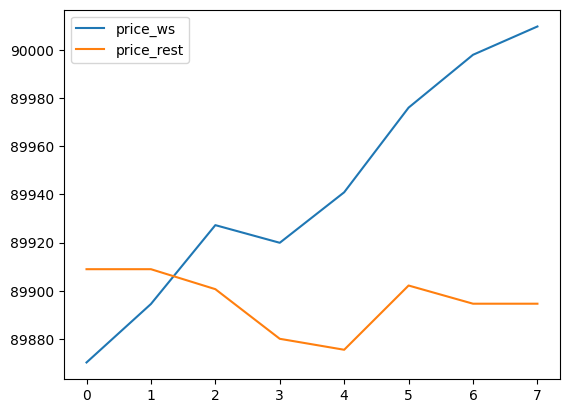

In [132]:
compare_df = df_web_socket.join(
    df_rest[["price","highest", "lowest", "ma_10", "ma_20"]],
    how="inner",
    lsuffix="_ws",
    rsuffix="_rest"
)
compare_df.plot(y=["price_ws","price_rest"])

In [133]:
user = os.environ["POSTGRE_USER"]      
password = os.environ["POSTGRE_PASS"]
host = "c3a9wim9rq.gyxknhzigc.tsdb.cloud.timescale.com"
port = 33547
database = "tsdb"
engine = create_engine(f"postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}")

In [134]:
df_web_socket.to_sql(
    "trades",
    engine,
    if_exists="append",
    index=False
)
df_rest.to_sql(
    "trades",
    engine,
    if_exists="append",
    index=False
)

8

In [135]:
query = """
SELECT * -- I know it's a bad practice, just for the project purposes.
FROM trades
WHERE instrument = :instrument
  AND ts BETWEEN :start AND :end
ORDER BY ts
"""

df = pandas.read_sql(
    text(query),
    engine,
    params={
        "instrument": "BTCUSDT",
        "start": "2026-01-02 00:00",
        "end": "2026-01-02 23:00"
    }
)

df.head()

,ts,instrument,price,volume,highest,lowest,ma_10,ma_20,data_source
0,2026-01-02 20:32:00+00:00,BTCUSDT,89821.076433,1424.00000,89835.69,89812.71,89821.076433,89821.076433,WEBSOCKET
1,2026-01-02 20:33:00+00:00,BTCUSDT,89836.733758,2608.00000,89861.88,89812.71,89828.905095,89828.905095,WEBSOCKET
2,2026-01-02 20:34:00+00:00,BTCUSDT,89841.708798,2288.00000,89884.85,89814.21,89833.172996,89833.172996,WEBSOCKET
3,2026-01-02 20:35:00+00:00,BTCUSDT,89938.040000,0.89255,89938.04,89884.84,89938.040000,89938.040000,REST_API
4,2026-01-02 20:35:00+00:00,BTCUSDT,89912.216877,2328.00000,89945.75,89884.84,89852.933966,89852.933966,WEBSOCKET
